# Quake

By Cascade Tuholske, June 2020

Notebook finds zonal stats of populations for 2015 Nepal earthquakes by raster. <br><br>
**NOTE** CRS should be epsg:4326 for everything!

In [1]:
#### Dependencies
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from rasterstats import zonal_stats, gen_zonal_stats
from glob import glob
import matplotlib.pyplot as plt

In [2]:
#### Functions
def zone_loop(polys_in, rst_list, stats_type, col, split):
    """ Function loops through rasters, calcs zonal_stats and returns stats as a data frame.
    Args:
        polys_in = polygons
        rst_list = list of paths & fns of rasters
        stats_type = stats type for each poly gone (see zonal stats)
        col = column to merge it all
        split = where to split the file name string (e.g. _matched.tif)
    """
    
    # copy polys to write out
    polys_out = polys_in.copy()
    
    for rst in rst_list:
        
        # Get data name
        data = rst.split(DATA_PATH+'interim/')[1].split(split)[0]
        print('Started', data)
        
        # Run zonal stats
        zs_feats = zonal_stats(polys_in, rst, stats=stats_type, geojson_out=True)
        zgdf = gpd.GeoDataFrame.from_features(zs_feats, crs=polys_in.crs)
        
        # Rename columns and merge
        zgdf = zgdf.rename(columns={stats_type: data+'_'+stats_type})
        
        polys_out = polys_out.merge(zgdf[[col, data+'_'+stats_type]], on = col, how = 'inner')
    
    return polys_out

In [3]:
def poly_prep(polys_fn, col):
    "function opens earth quake polygons for zonal loop"
    
    # open
    polys = gpd.read_file(polys_fn)
    
    # subset, be sure to check the admin level
    polys = polys[['geometry', col]]
    
    return polys

## Run on Quake Intensity Contours (MI) from USGS for Nepal 2015



In [4]:
# Git tif files
rst_fns = sorted(glob('/Users/cascade/Github/PopGridCompare/data/interim/*all_NPL.tif'))
rst_fns

['/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_all_NPL.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GHS15_all_NPL.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_all_NPL.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/LS15_all_NPL.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/WP16_all_NPL.tif']

In [5]:
# open polys
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'
nepal_polys_fn = DATA_PATH+'raw/USGS_Data/Nepal/shape/mi.shp'

col = 'PARAMVALUE'
nepal_polys = poly_prep(nepal_polys_fn, col)

In [6]:
# Run zonal stats loop
nepal_polys_sum = zone_loop(nepal_polys, rst_fns, 'sum', col, '_all_NPL.tif')

Started ESRI16
Started GHS15
Started GPWv4
Started LS15
Started WP16


In [7]:
#### Save the poly sums
nepal_polys_sum.to_file(DATA_PATH+'/processed/nepal_quake_pop.shp')

# Plots

In [8]:
#### set colors
ESRI16_c = 'blue'
GHS15_c = 'indigo'
GWPv4_c = 'deeppink'
LS15_c = 'deepskyblue'
WP16_c = 'forestgreen'

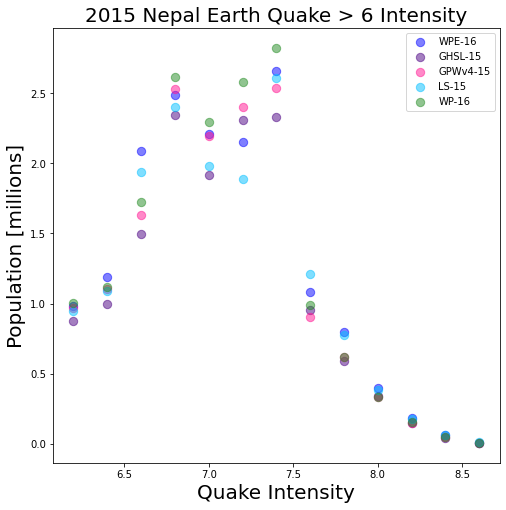

In [9]:
#### plot it Nepal
data = nepal_polys_sum[nepal_polys_sum['PARAMVALUE'] > 6]
title = '2015 Nepal Earth Quake > 6 Intensity'
scale = 10**6

fig, axs = plt.subplots(1, 1, figsize = (8, 8), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)

axs.scatter(data['PARAMVALUE'], data['ESRI16_sum'] / scale, color = ESRI16_c, alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['GHS15_sum'] / scale, color = GHS15_c, alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['GPWv4_sum'] / scale, color = GWPv4_c,  alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['LS15_sum'] / scale, color = LS15_c, alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['WP16_sum'] / scale, color = WP16_c, alpha = 0.5, s = 70)

axs.set_title(title, size = 20 )
axs.set_xlabel('Quake Intensity', fontsize = 20)
axs.set_ylabel('Population [millions]', fontsize = 20)
#plt.ylim([100,10000000])

plt.yscale('linear')
axs.ticklabel_format(useOffset=False, style = 'plain')

labels = ['WPE-16', 'GHSL-15', 'GPWv4-15', 'LS-15', 'WP-16']
plt.legend(labels)

# save it out
fig_out = '/Users/cascade/Github/PopGridCompare/data/FIGS/MS/Finalv1/Nepal2015_all.png'
plt.savefig(fig_out, dpi = 300, facecolor = 'white', bbox_inches='tight')

# Urban

In [10]:
# Git tif files
rst_fns = sorted(glob('/Users/cascade/Github/PopGridCompare/data/interim/*_urban_NPL.tif'))
rst_fns

['/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_urban_NPL.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GHS15_urban_NPL.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_urban_NPL.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/LS15_urban_NPL.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/WP16_urban_NPL.tif']

In [11]:
# open polys
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'
nepal_polys_fn = DATA_PATH+'raw/USGS_Data/Nepal/shape/mi.shp'

col = 'PARAMVALUE'
nepal_polys = poly_prep(nepal_polys_fn, col)


In [12]:
# Run zonal stats loop
nepal_polys_sum = zone_loop(nepal_polys, rst_fns, 'sum', col, '_urban_NPL.tif')


Started ESRI16
Started GHS15
Started GPWv4
Started LS15
Started WP16


In [13]:
#### Save the poly sums
nepal_polys_sum.to_file(DATA_PATH+'/processed/nepal_urban_quake_pop.shp')

In [14]:
nepal_polys_sum

,geometry,PARAMVALUE,ESRI16_sum,GHS15_sum,GPWv4_sum,LS15_sum,WP16_sum
0,"MULTIPOLYGON (((90.08423 31.91667, 90.08387 31...",2.8,NaN,NaN,NaN,NaN,NaN
1,"MULTIPOLYGON (((81.46715 31.90000, 81.46696 31...",3.0,NaN,NaN,NaN,NaN,NaN
2,"MULTIPOLYGON (((81.97315 31.91667, 81.97108 31...",3.2,NaN,NaN,NaN,NaN,NaN
3,"MULTIPOLYGON (((82.98663 31.91667, 82.98523 31...",3.4,0.0,0.000000e+00,0.000000,0.0,0.000000e+00
4,"MULTIPOLYGON (((84.81601 31.93333, 84.80491 31...",3.6,0.0,0.000000e+00,0.000000,0.0,0.000000e+00
5,"MULTIPOLYGON (((85.14253 31.75000, 85.14092 31...",3.8,0.0,0.000000e+00,0.000000,0.0,0.000000e+00
6,"MULTIPOLYGON (((84.66259 31.40000, 84.65680 31...",4.0,0.0,0.000000e+00,0.000000,0.0,0.000000e+00
7,"MULTIPOLYGON (((85.13591 31.01667, 85.13522 31...",4.2,38314.0,5.509021e+04,22884.103516,41879.0,3.542495e+04
8,"MULTIPOLYGON (((84.80292 30.56667, 84.80248 30...",4.4,0.0,0.000000e+00,0.000000,0.0,0.000000e+00
9,"MULTIPOLYGON (((84.68411 30.28333, 84.68384 30...",4.6,0.0,0.000000e+00,0.000000,0.0,0.000000e+00


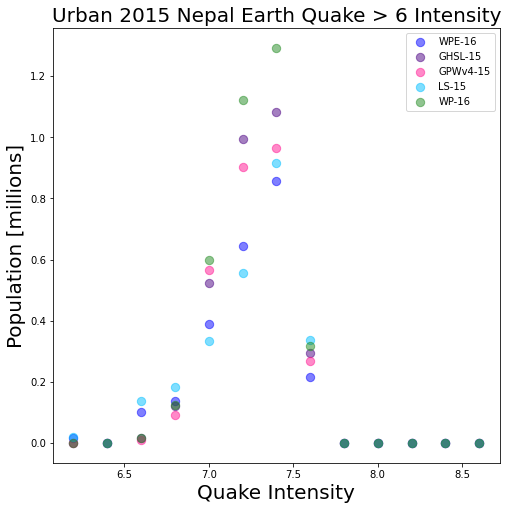

In [15]:
#### plot it Nepal
data = nepal_polys_sum[nepal_polys_sum['PARAMVALUE'] > 6]
title = 'Urban 2015 Nepal Earth Quake > 6 Intensity'
scale = 10**6

fig, axs = plt.subplots(1, 1, figsize = (8, 8), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)

axs.scatter(data['PARAMVALUE'], data['ESRI16_sum'] / scale, color = ESRI16_c, alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['GHS15_sum'] / scale, color = GHS15_c, alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['GPWv4_sum'] / scale, color = GWPv4_c,  alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['LS15_sum'] / scale, color = LS15_c, alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['WP16_sum'] / scale, color = WP16_c, alpha = 0.5, s = 70)

axs.set_title(title, size = 20 )
axs.set_xlabel('Quake Intensity', fontsize = 20)
axs.set_ylabel('Population [millions]', fontsize = 20)
#plt.ylim([100,10000000])

plt.yscale('linear')
axs.ticklabel_format(useOffset=False, style = 'plain')

labels = ['WPE-16', 'GHSL-15', 'GPWv4-15', 'LS-15', 'WP-16']
plt.legend(labels)

# save it out
fig_out = '/Users/cascade/Github/PopGridCompare/data/FIGS/MS/Finalv1/Nepal2015_urban.png'
plt.savefig(fig_out, dpi = 300, facecolor = 'white', bbox_inches='tight')

# Rural

In [16]:
# Git tif files
rst_fns = glob('/Users/cascade/Github/PopGridCompare/data/interim/*_rural_NPL.tif')
rst_fns

['/Users/cascade/Github/PopGridCompare/data/interim/WP16_rural_NPL.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_rural_NPL.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GHS15_rural_NPL.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/LS15_rural_NPL.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_rural_NPL.tif']

In [17]:
# open polys
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'
nepal_polys_fn = DATA_PATH+'raw/USGS_Data/Nepal/shape/mi.shp'

col = 'PARAMVALUE'
nepal_polys = poly_prep(nepal_polys_fn, col)


In [18]:
# Run zonal stats loop
nepal_polys_sum = zone_loop(nepal_polys, rst_fns, 'sum', col, '_rural_NPL.tif')


Started WP16
Started ESRI16
Started GHS15
Started LS15
Started GPWv4


In [19]:
#### Save the poly sums
nepal_polys_sum.to_file(DATA_PATH+'/processed/nepal_rural_quake_pop.shp')

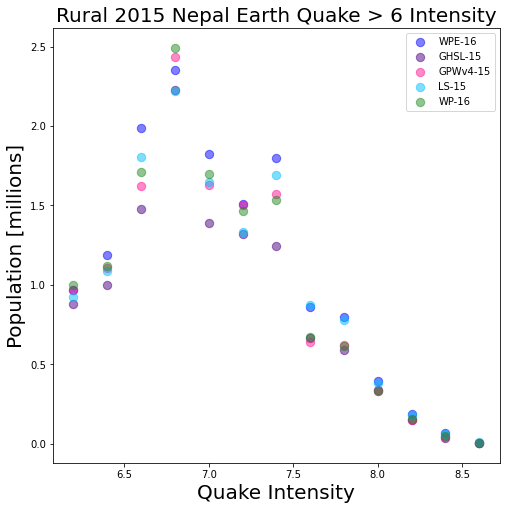

In [23]:
#### plot it Nepal
data = nepal_polys_sum[nepal_polys_sum['PARAMVALUE'] > 6]
title = 'Rural 2015 Nepal Earth Quake > 6 Intensity'
scale = 10**6

fig, axs = plt.subplots(1, 1, figsize = (8, 8), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)

axs.scatter(data['PARAMVALUE'], data['ESRI16_sum'] / scale, color = ESRI16_c, alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['GHS15_sum'] / scale, color = GHS15_c, alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['GPWv4_sum'] / scale, color = GWPv4_c,  alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['LS15_sum'] / scale, color = LS15_c, alpha = 0.5, s = 70)
axs.scatter(data['PARAMVALUE'], data['WP16_sum'] / scale, color = WP16_c, alpha = 0.5, s = 70)

axs.set_title(title, size = 20 )
axs.set_xlabel('Quake Intensity', fontsize = 20)
axs.set_ylabel('Population [millions]', fontsize = 20)
#plt.ylim([100,10000000])

plt.yscale('linear')
axs.ticklabel_format(useOffset=False, style = 'plain')

labels = ['WPE-16', 'GHSL-15', 'GPWv4-15', 'LS-15', 'WP-16']
plt.legend(labels)

# save it out
fig_out = '/Users/cascade/Github/PopGridCompare/data/FIGS/MS/Finalv1/Nepal2015_rural.png'
plt.savefig(fig_out, dpi = 300, facecolor = 'white', bbox_inches='tight')

## Analysis

In [21]:
# All
all_pop = gpd.read_file(DATA_PATH+'/interim/nepal_quake_pop.shp')
all_pop['max'] = all_pop.iloc[:,1:5].values.max(1)
all_pop['min'] = all_pop.iloc[:,1:5].values.min(1)
all_pop['dif'] = all_pop['max'] - all_pop['min']

DriverError: /Users/cascade/Github/PopGridCompare/data//interim/nepal_quake_pop.shp: No such file or directory

In [ ]:
# Urban 
urban_pop = gpd.read_file(DATA_PATH+'/interim/nepal_urban_quake_pop.shp')
urban_pop['max'] = urban_pop.iloc[:,1:5].values.max(1)
urban_pop['min'] = urban_pop.iloc[:,1:5].values.min(1)
urban_pop['dif'] = urban_pop['max'] - urban_pop['min']

In [ ]:
df = pd.DataFrame()
df['PARAMVALUE'] = urban_pop['PARAMVALUE']
df['dif'] = urban_pop['WP16_sum'] - urban_pop['GHS15_sum']
df;

In [ ]:
# rural 
rural_pop = gpd.read_file(DATA_PATH+'/interim/nepal_rural_quake_pop.shp')
rural_pop['max'] = rural_pop.iloc[:,1:5].values.max(1)
rural_pop['min'] = rural_pop.iloc[:,1:5].values.min(1)
rural_pop['dif'] = rural_pop['max'] - rural_pop['min']

In [ ]:
rural_pop